
   - **Context**:This dataset includes some feature of cars with it's price so we want to understand what features has more impact of the price

   - **Needs**: 
        We will start exploring the relationship between X1 , X2 , ..., Xp and Y and the X1 , X2 , ..., Xp , But before we get to that, a key step before undertaking any analysis is understanding the data.
        - How horsepower and engin size are related to car price ?
        - Is there a relation between car feature and price ? IF exist How strong the relation ?
        - Which feature are more associated with the price ?
        - How accurately can we predict a car price ?
        - Is the relationship linear ?
       
   - **Vision** : we would clean the data then analysis using some statistical methods.
       
   - **Outcome** : being able to predict a car price

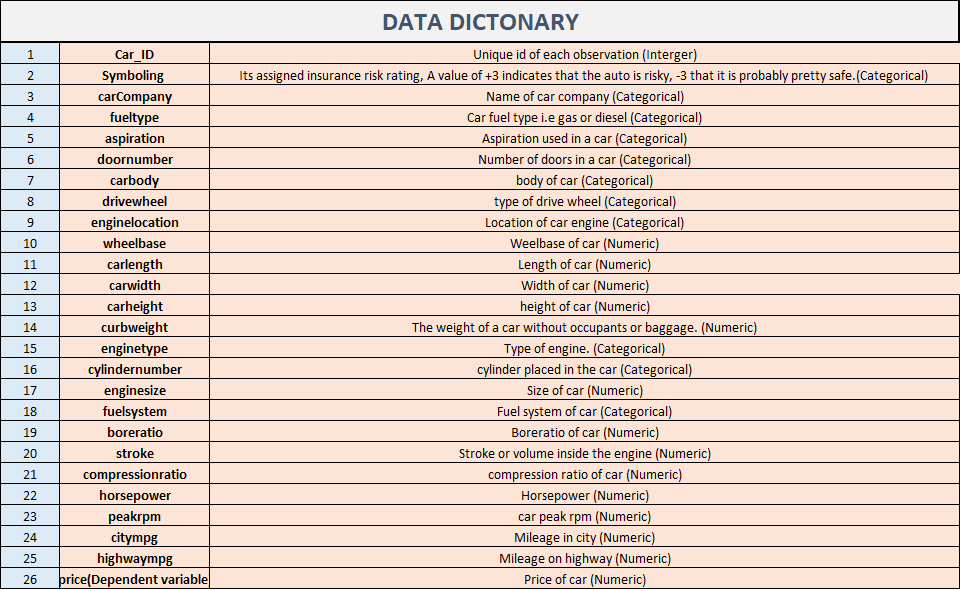

## Libraries

In [1]:
!pip install  bioinfokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.3-py3-none-any.whl size=59056 sha256=bb0203ac1542d4287497c4227d4e624feefcbfc013a470fdee8cd0149ead36f3
  Stored in directory: /root/.cache/pip/wheels/ac/67/a7/4e0b4172d5415933127e819d7d7080ae08a6220949ad2f6de5
Successfully built bioinfokit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import sys
sys.path.insert(1,'/kaggle/input/catreg')
from catReg import categoricalRegression
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

np.random.seed(0)


## Importing Data

In [3]:
df = pd.read_csv('/kaggle/input/car-data/CarPrice_Assignment.csv')
df.drop('car_ID' , axis = 1 , inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

nice no missing data

In [4]:
df.describe().mean() - df.describe().median()

symboling             25.262278
wheelbase              3.519002
carlength            -15.726315
carwidth               9.565224
carheight             12.383611
curbweight          -238.344243
enginesize            16.365093
boreratio             24.820197
stroke                24.804669
compressionratio      25.314322
horsepower            21.149118
peakrpm             -955.422526
citympg               21.860451
highwaympg            19.829098
price               4179.894197
dtype: float64

#### Inference :
   1. Always compare mean and median with your eyes as If the distribution is symmetric then the mean is equal to the median and the distribution will have zero skewness , it seems that we have right skewness in price let's check that .

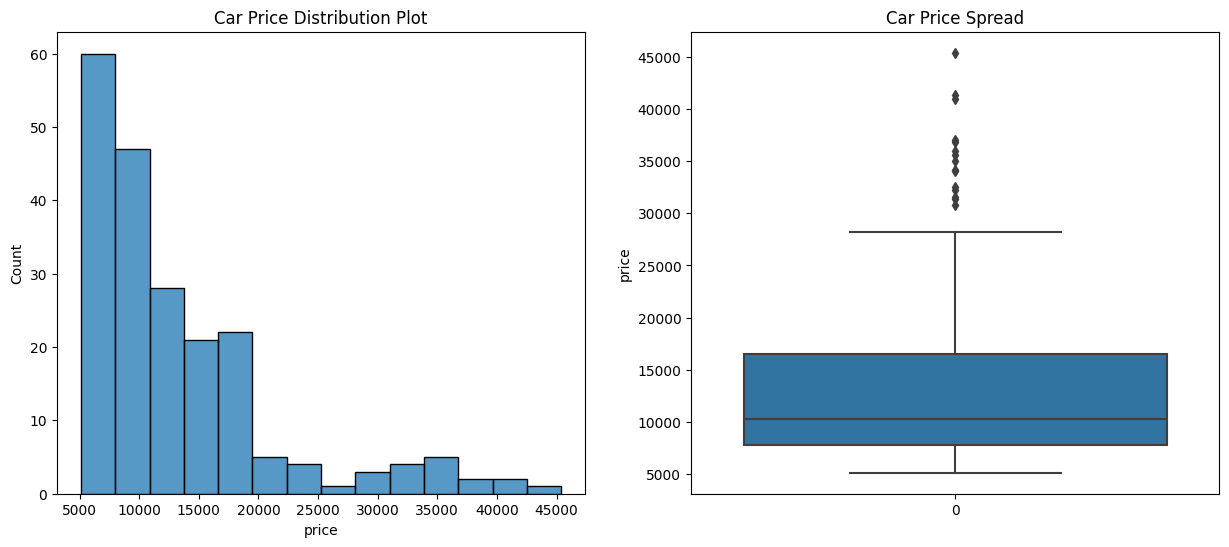

In [5]:
fig , ax = plt.subplots(1 , 2 ,figsize=(15,6))

ax[0].set_title('Car Price Distribution Plot')
sns.histplot(df['price'] ,ax=ax[0])



ax[1].set_title('Car Price Spread' )
ax[1].set_ylabel('price')
sns.boxplot(df['price'],ax = ax[1])

plt.show()

Despite Linear regression does not necessarily require the dependent variable to be normally distributed  However, when the dependent variable is strongly skewed or has extreme outliers, it may be appropriate to transform the variable using a logarithmic or other transformation to improve the normality of the residuals ,but i prefer to keep it till we need it

In [6]:
print(df.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
85%      18500.000000
90%      22563.000000
100%     45400.000000
max      45400.000000
Name: price, dtype: float64


#### Inference :
   1. The plot seemed to be right-skewed, the most prices in the dataset are low(Below 15,000).
   2. Due to skewness we have a high variance (85% of the prices are below 18,500 where the remaining 15% are up to 45,400).

## Exploratory Data Analysis

#### Q1 | How horsepower and engin size are related to car price ?

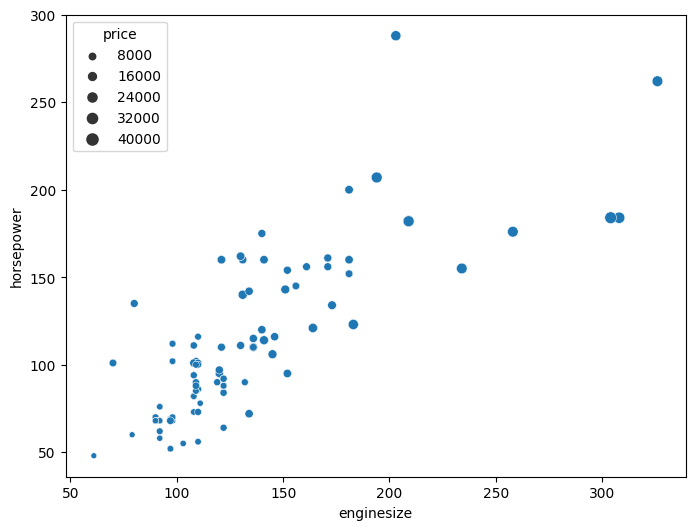

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(data =df ,y = 'horsepower' , x = 'enginesize',size='price')
plt.show()

#### Inference :
   1. As expected that increasing the size of the engine would increase the horsepower which increase the price

#### Q2 | Dose Car dimension related price?

In [8]:
def scatter(features , nrow , ncol):
    fig, ax = plt.subplots(nrow, ncol, figsize=(8, 6))
    ax = ax.flatten()
    
    for i, axis in enumerate(ax):
        axis.scatter(df[features[i]], df['price'] ,alpha = 0.8)
        axis.set_title(features[i] + ' vs Price ' + str(np.round(np.corrcoef(df[features[i]], df['price'] )[0][1] , 2)))
        axis.set_ylabel('Price')
        axis.set_xlabel(features[i])
    features.append('price')
    
    plt.tight_layout()
    plt.show()
    

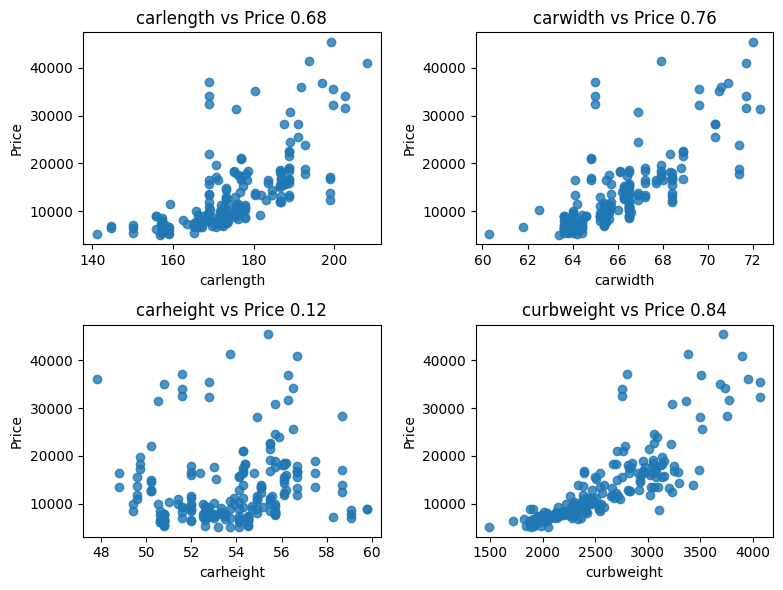

In [9]:
scatter(['carlength' , 'carwidth', 'carheight' , 'curbweight'] , nrow=2 , ncol=2)

### Inference :
  1. carwidth, carlength and curbweight seems to have a poitive correlation with price.
  2. carheight doesn't show any significant trend with price.
  3. we have a high Multicollinearity  between carwidth and curbweight , we will use the $ Recursive Feature Elimination$

In [10]:
df.drop('carheight' ,axis = 1 , inplace=True)

#### Q3 | Dose fuel efficiency afftect car price?

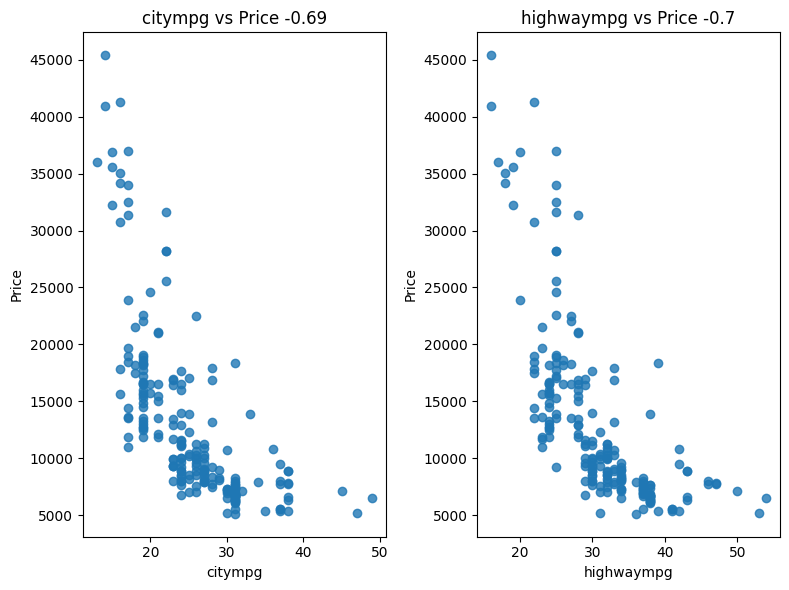

In [11]:
scatter(['citympg' , 'highwaympg'] , nrow=1 , ncol=2)

#### Inference :
   1. More fuel-efficient vehicles, which can cover more distance per gallon of fuel, tend to be priced lower compared to less fuel-efficient vehicles.
   2. it seem that we have collinearity between these two variable so we can replace with average value

In [12]:
df['fuelefficient'] = np.average(df[['highwaympg' , 'citympg']] , axis = 1)
df.drop(['highwaympg' , 'citympg'] , axis = 1 , inplace=True)

before using the model let's deal with our categorical data

In [13]:
df.select_dtypes(include=object).nunique()

CarName           147
fueltype            2
aspiration          2
doornumber          2
carbody             5
drivewheel          3
enginelocation      2
enginetype          7
cylindernumber      7
fuelsystem          8
dtype: int64

as you can see we need to deal with $carname$ because that huge number will ruin our regression (lead to a high-dimensional feature space, which may result in overfitting or make the regression model computationally expensive.) , we could just use the brand instead of full name

In [14]:
brands = pd.Series([x.split()[0] for x in df['CarName'].str.lower()])
print(f'there are {brands.nunique()} and they are :\n' , brands.unique())

there are 27 and they are :
 ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'nissan' 'peugeot'
 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru' 'toyota'
 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']


it seems that we have some spelling error

In [15]:
def replace_name(old , new):
    for brand in brands:
        brands.replace(old , new , inplace=True)

In [16]:
replace_name('maxda','mazda')
replace_name('porcshce','porsche')
replace_name('toyouta','toyota')
replace_name('vokswagen','volkswagen')
replace_name('vw','volkswagen')

In [17]:
print(f'there are {brands.nunique()} and they are :\n' , brands.unique())

there are 22 and they are :
 ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'buick' 'mercury' 'mitsubishi' 'nissan' 'peugeot' 'plymouth'
 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']


we will deal with that later but let's keep analysis

In [18]:
df.drop('CarName' , axis = 1 , inplace=True)
df['brand'] = brands

#### Q4 | What is the highest average price car company?

In [19]:
brand_average = df[['price','brand']].groupby('brand').agg(np.mean)['price'].sort_values(ascending=False)

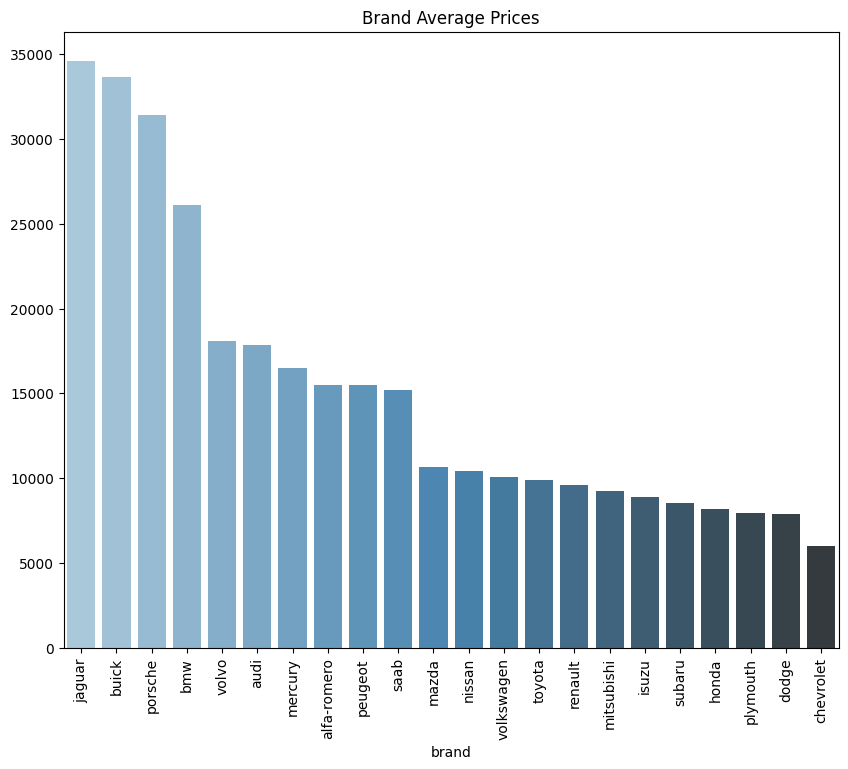

In [20]:
plt.figure(figsize=(10,8))
sns.barplot(data=df , x = brand_average.index , y =brand_average.values , palette=("Blues_d") )
plt.xticks(rotation = 90)
plt.title('Brand Average Prices')
plt.show()

#### inference:
  1. Jaguar and Buick seem to have highest average price.

#### Q5 | What is the relation between engine type and price?

In [21]:
catreg = categoricalRegression('price' , df )

p-value for significant difference between categories : 4.287270740376635e-07


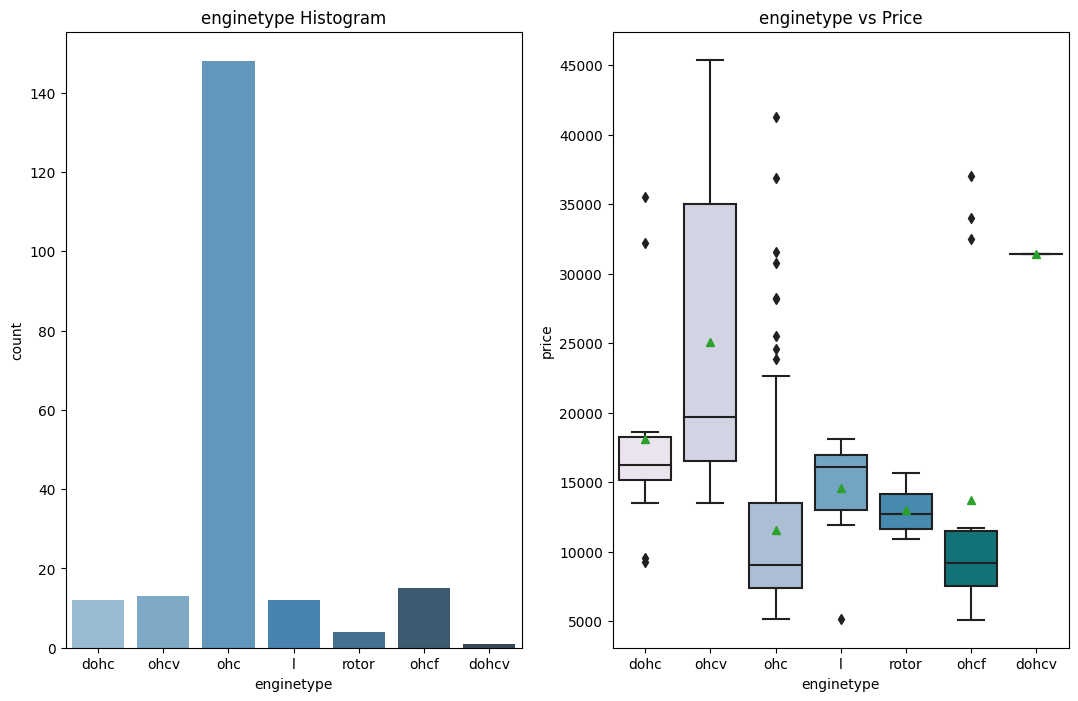

In [22]:
catreg.cate_info('enginetype')

#### inference:
  1. ohc is the most selled
  2. ohcv has the highest average price as dohcv has one value while ohc and ohcf has the lowest price


#### Q6 | Is the number of door make any difference?

p-value for significant difference between categories : 0.09096288374664191


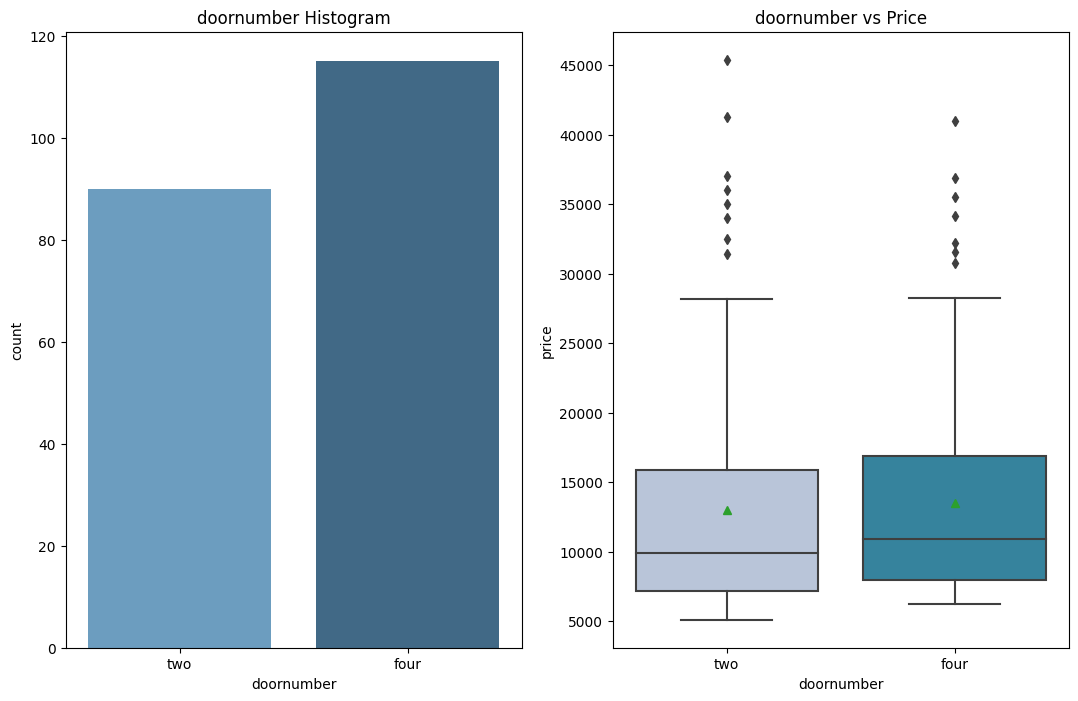

In [23]:
catreg.cate_info('doornumber')

#### inference:
  1. it seems that there is no statistcally difference between the variable as p-value is larger than 0.05

#### Q7 | What about the remaining categorical variable?

p-value for significant difference between categories : 0.04616736846226526


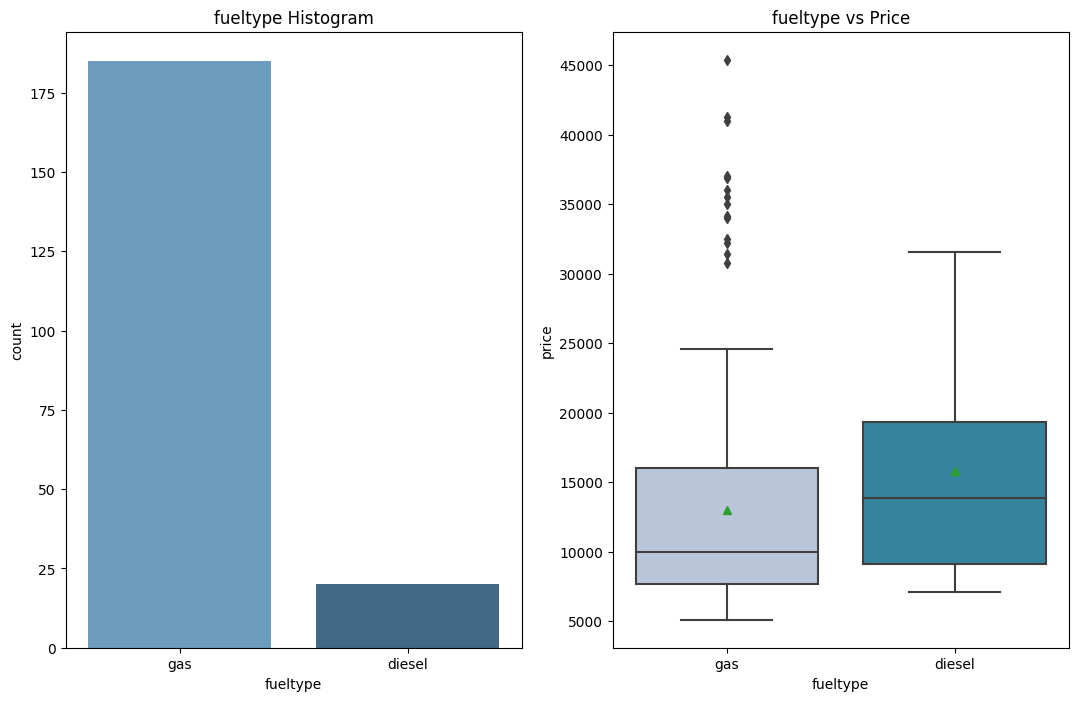

In [24]:
catreg.cate_info('fueltype')

p-value for significant difference between categories : 0.0001842534808688567


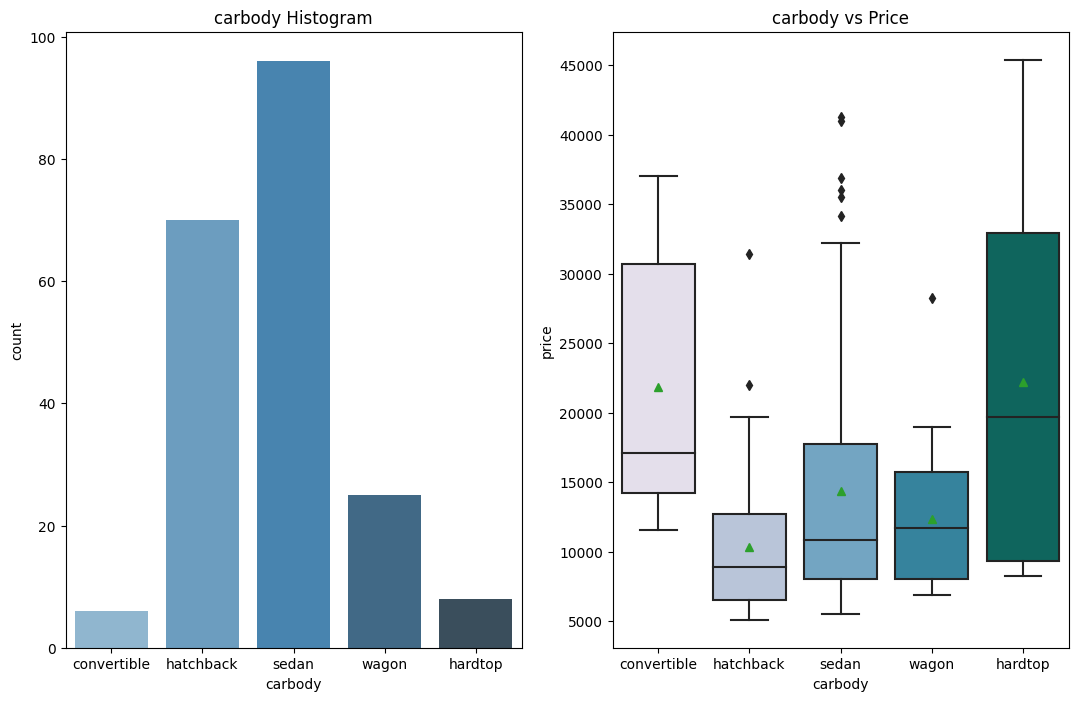

In [25]:
catreg.cate_info('carbody')

p-value for significant difference between categories : 3.696266502144558e-16


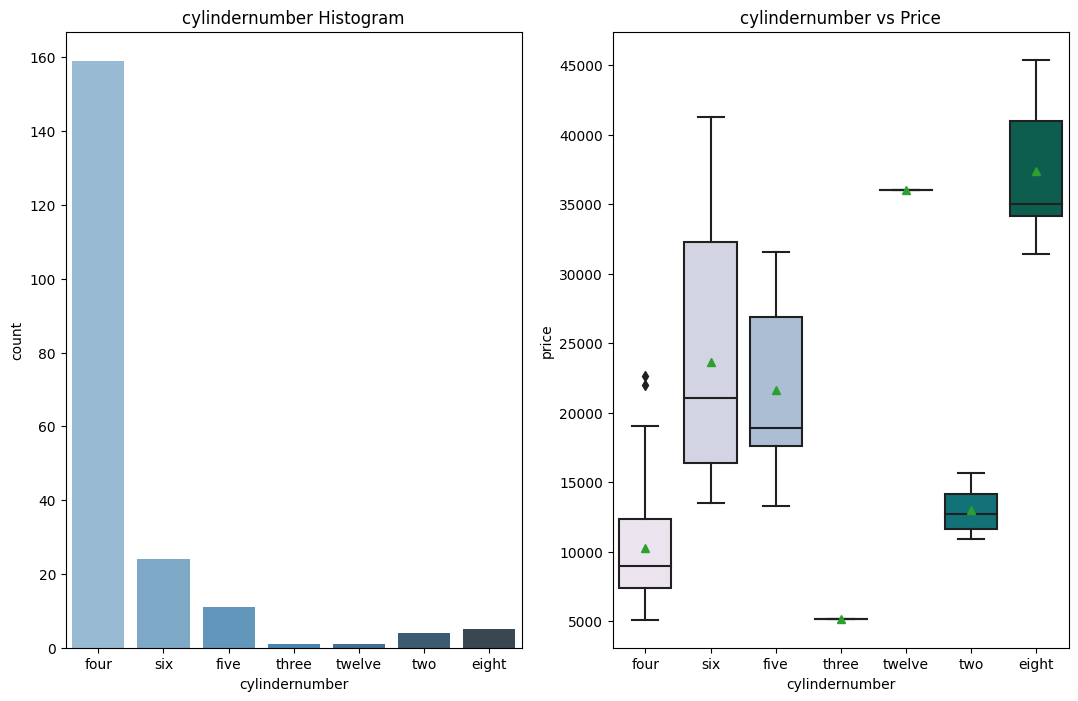

In [26]:
catreg.cate_info('cylindernumber')

p-value for significant difference between categories : 6.683871002354369e-24


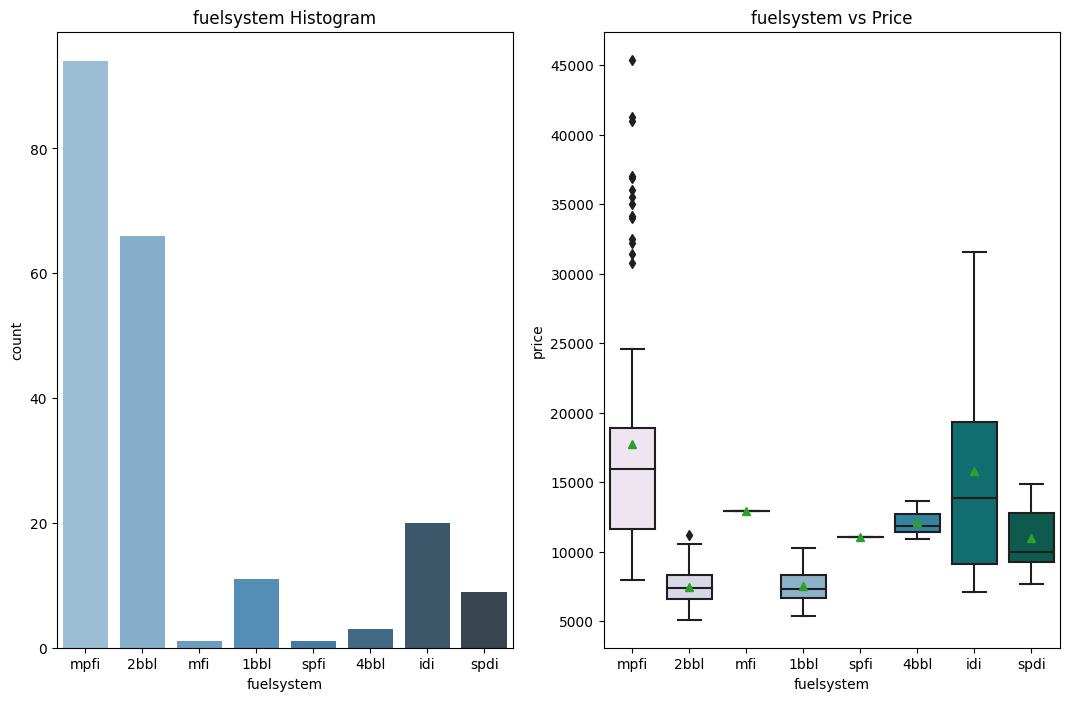

In [27]:
catreg.cate_info('fuelsystem')

p-value for significant difference between categories : 0.005443245674744495


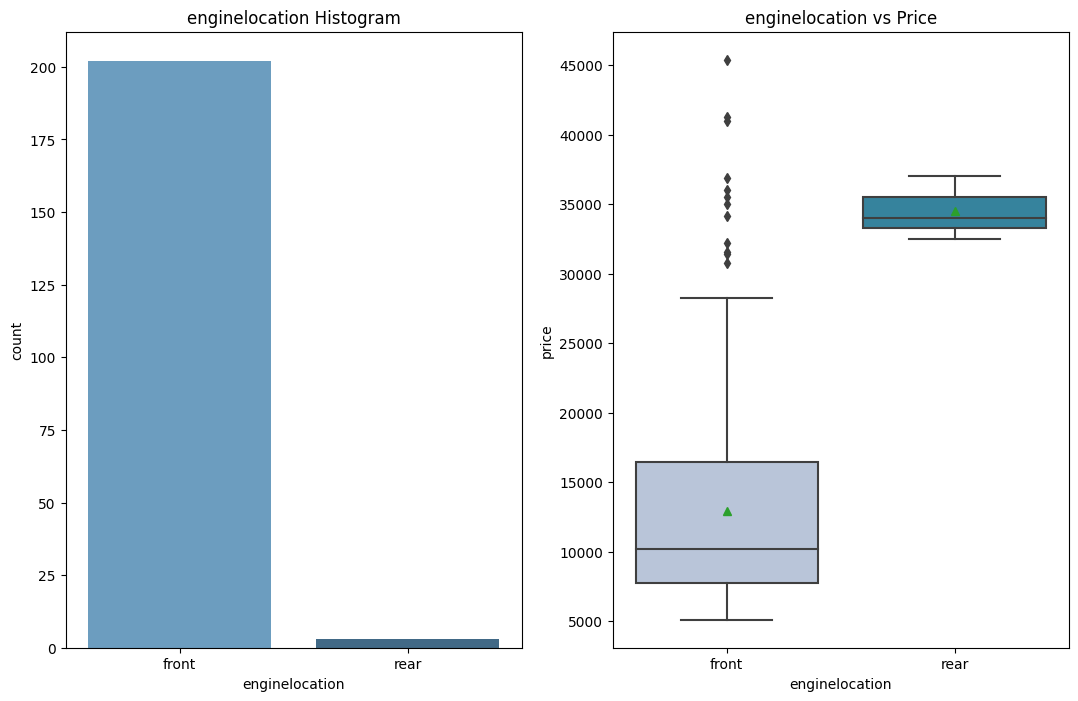

In [28]:
catreg.cate_info('enginelocation')

Data science is an art more than science, Despite statistics saying that there is statistical significance between categorical variables, we have very few categories to make inferences

p-value for significant difference between categories : 1.27396055410436e-10


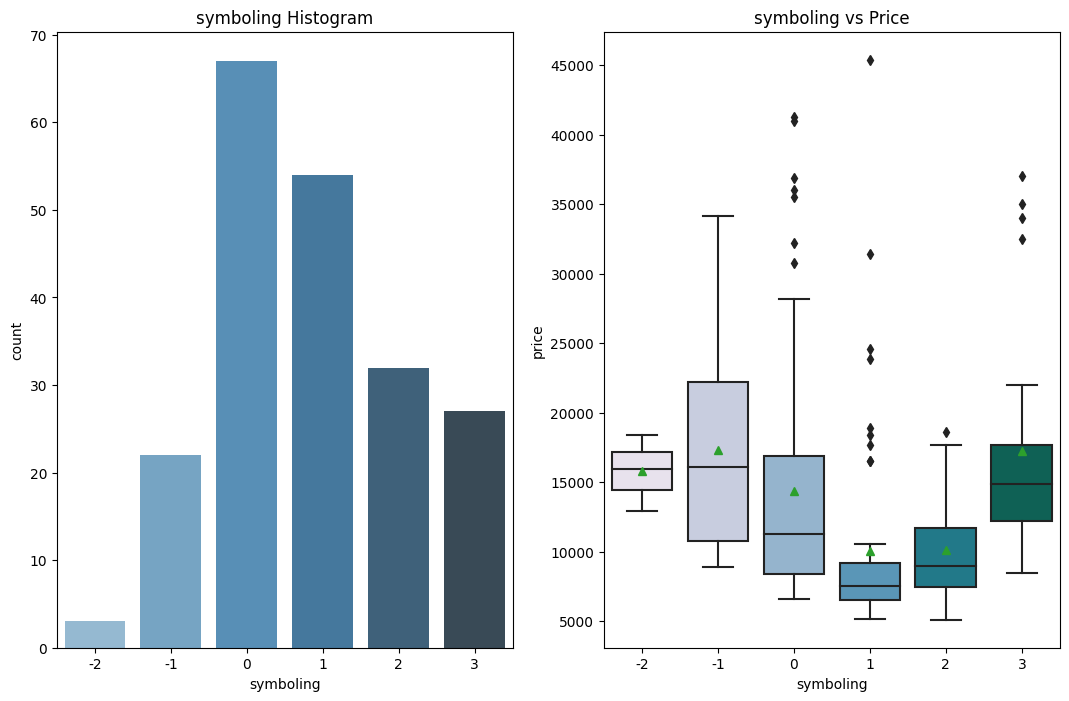

In [29]:
catreg.cate_info('symboling')

p-value for significant difference between categories : 1.027454898989684e-05


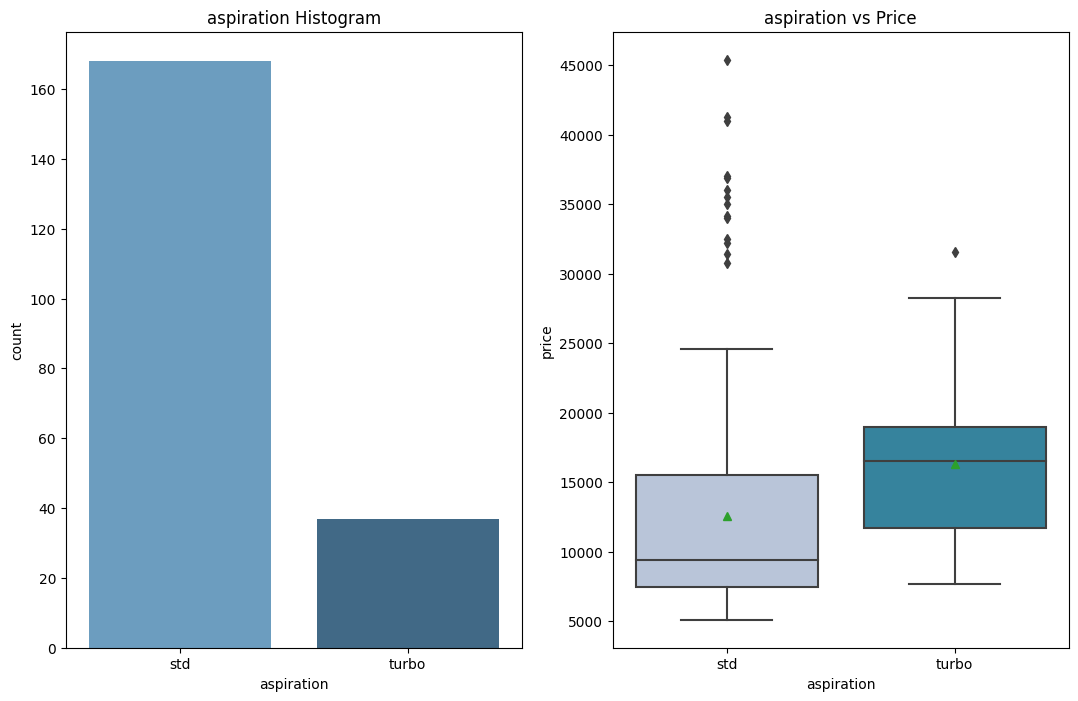

In [30]:
catreg.cate_info('aspiration')

 after these visulization we cen select the categorical variable that seems to have any impact of the model

## Feature Engineering 

#### Categorical variable that show  significant:
   1. symboling
   2. fueltype
   3. aspiration
   4. carbody
   5. drivewheel
   6. enginetype
   7. fuelsystem

In [31]:
def target_encoding(df_train, target_col, encode_col):
    'this function is replacing the encode_col with a one of [low , mediun , high] bins'
    
    means = df_train.groupby(encode_col)[target_col].mean()  
    encoded_col_name = 'brandrange'
    bins = [0,10000,20000,40000]
    cars_bin=['low','Medium','high']
    df_train[encoded_col_name] = pd.cut(df_train[encode_col].map(means)  ,bins,right=False,labels=cars_bin )
    df_train.drop(encode_col , axis = 1 , inplace = True)
    return df_train

In [32]:
df = target_encoding(df , 'price' , 'brand')
df

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price,fuelefficient,brandrange
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,13495.0,24.0,Medium
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,16500.0,24.0,Medium
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,16500.0,22.5,Medium
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,13950.0,27.0,Medium
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,17450.0,20.0,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,141,mpfi,3.78,3.15,9.5,114,5400,16845.0,25.5,Medium
201,-1,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,...,141,mpfi,3.78,3.15,8.7,160,5300,19045.0,22.0,Medium
202,-1,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,...,173,mpfi,3.58,2.87,8.8,134,5500,21485.0,20.5,Medium
203,-1,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,...,145,idi,3.01,3.40,23.0,106,4800,22470.0,26.5,Medium


let's test the numerical variables , as a beginning step at solving the multicollinearity we need to solve collinearity so we check the covariance matrix drop the 


<Axes: >

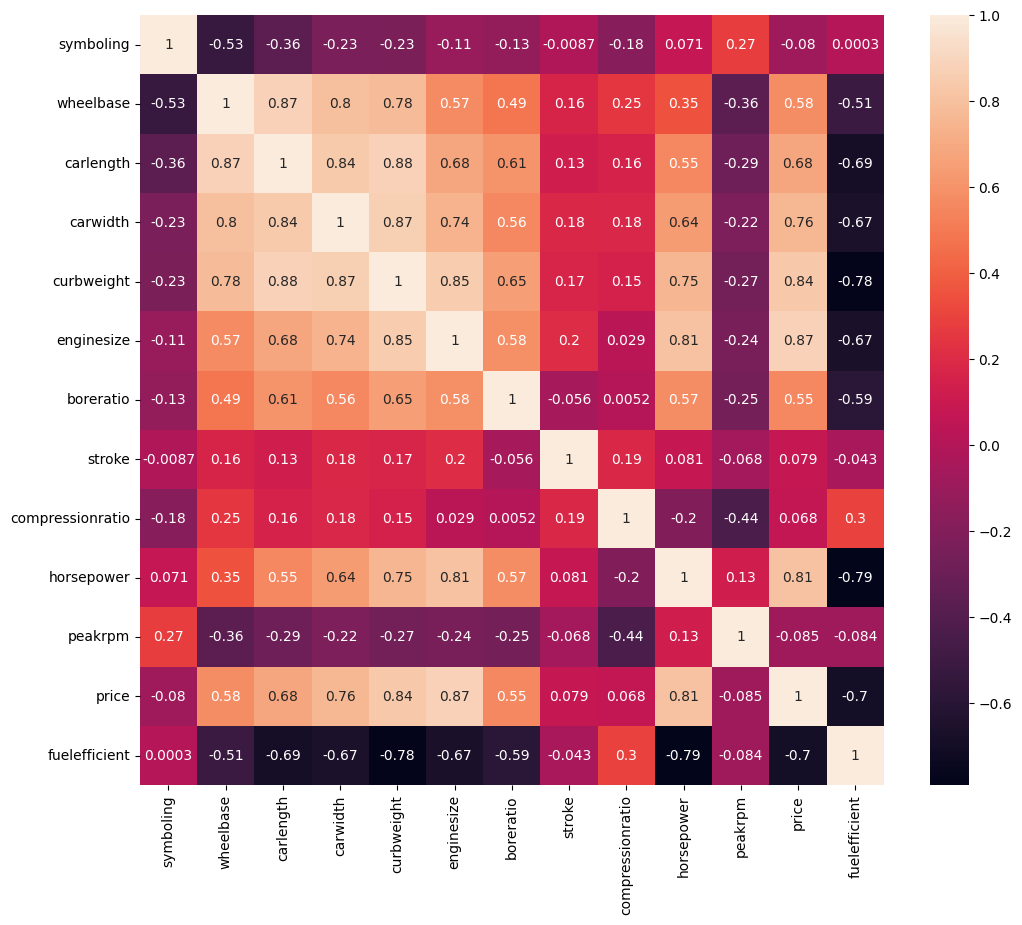

In [33]:
plt.figure(figsize=(12,10))
# that caued a problem
numerical_variable = df.select_dtypes(exclude=['object' , 'category']).columns
sns.heatmap(df[numerical_variable].corr() , annot=True)

variable like
  - stroke
  - compressionratio 
  - peakrpm
  
has a weak correlation with price(target variable)

In [34]:
y = df['price']
df = df[['symboling', 'fueltype', 'aspiration', 'carbody',
       'drivewheel', 'wheelbase', 'carlength', 'carwidth',
       'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'horsepower', 'fuelefficient', 'brandrange']]

In [35]:
numerical_columns = df.select_dtypes(exclude=['object' , 'category']).columns
categorical_columns = df.select_dtypes(include=['object' , 'category']).columns

In [36]:
df_dummies = pd.get_dummies(df, drop_first = True,dtype=float )

In [37]:
def get_baseline(df ,categorical_columns ,  df_dummies):
    # Step 1: Create a dictionary of dummy columns for each original categorical column
    columns_dummies = {}
    for dummy_column in df_dummies.columns:
        column  = dummy_column.split('_')
        if len(column) > 1 :
            columns_dummies.setdefault(column[0], []).append(column[1])

    # Step 2: Find baseline values for each categorical column             
    column_baselines = {}
    for column in df[categorical_columns] :
        for value in df[column].unique():
            if value not in columns_dummies[column] :
                column_baselines[column] = value
                
                
    return column_baselines

In [38]:
column_baselines = get_baseline(df , categorical_columns , df_dummies)
column_baselines

{'fueltype': 'diesel',
 'aspiration': 'std',
 'carbody': 'convertible',
 'drivewheel': '4wd',
 'enginetype': 'dohc',
 'cylindernumber': 'eight',
 'fuelsystem': '1bbl',
 'brandrange': 'low'}

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies ,  y , train_size = 0.8, random_state = 100)

In [40]:
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform( X_train[numerical_columns] )
X_test[numerical_columns] = scaler.transform( X_test[numerical_columns] )

## Modeling

In [41]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,n_features_to_select = 10)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('symboling', False, 28),
 ('wheelbase', False, 17),
 ('carlength', False, 22),
 ('carwidth', False, 9),
 ('curbweight', True, 1),
 ('enginesize', False, 21),
 ('boreratio', False, 15),
 ('horsepower', True, 1),
 ('fuelefficient', False, 12),
 ('fueltype_gas', False, 27),
 ('aspiration_turbo', False, 23),
 ('carbody_hardtop', True, 1),
 ('carbody_hatchback', True, 1),
 ('carbody_sedan', True, 1),
 ('carbody_wagon', True, 1),
 ('drivewheel_fwd', False, 20),
 ('drivewheel_rwd', False, 13),
 ('enginetype_dohcv', True, 1),
 ('enginetype_l', False, 4),
 ('enginetype_ohc', False, 5),
 ('enginetype_ohcf', False, 6),
 ('enginetype_ohcv', False, 10),
 ('enginetype_rotor', False, 26),
 ('cylindernumber_five', False, 7),
 ('cylindernumber_four', True, 1),
 ('cylindernumber_six', False, 8),
 ('cylindernumber_three', False, 14),
 ('cylindernumber_twelve', True, 1),
 ('cylindernumber_two', False, 24),
 ('fuelsystem_2bbl', False, 19),
 ('fuelsystem_4bbl', False, 18),
 ('fuelsystem_idi', False, 25),


In [42]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,curbweight,horsepower,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,enginetype_dohcv,cylindernumber_four,cylindernumber_twelve,brandrange_high
3,-0.343330,0.024240,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
157,-0.781780,-0.791203,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
81,-0.360637,-0.332517,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
32,-1.304842,-1.046029,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
99,-0.368329,-0.103173,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
def build_model(X,y , print_summary = True):
    'This function is building the model and return the summary and results '
    X = sm.add_constant(X) 
    lm = sm.OLS(y,X).fit()
    if print_summary:
        print(lm.summary()) 
    return X , lm

In [44]:
X_train_tmp , model  = build_model( X_train_rfe , y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     185.9
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           3.04e-80
Time:                        08:59:32   Log-Likelihood:                -1488.4
No. Observations:                 164   AIC:                             2999.
Df Residuals:                     153   BIC:                             3033.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.74e+

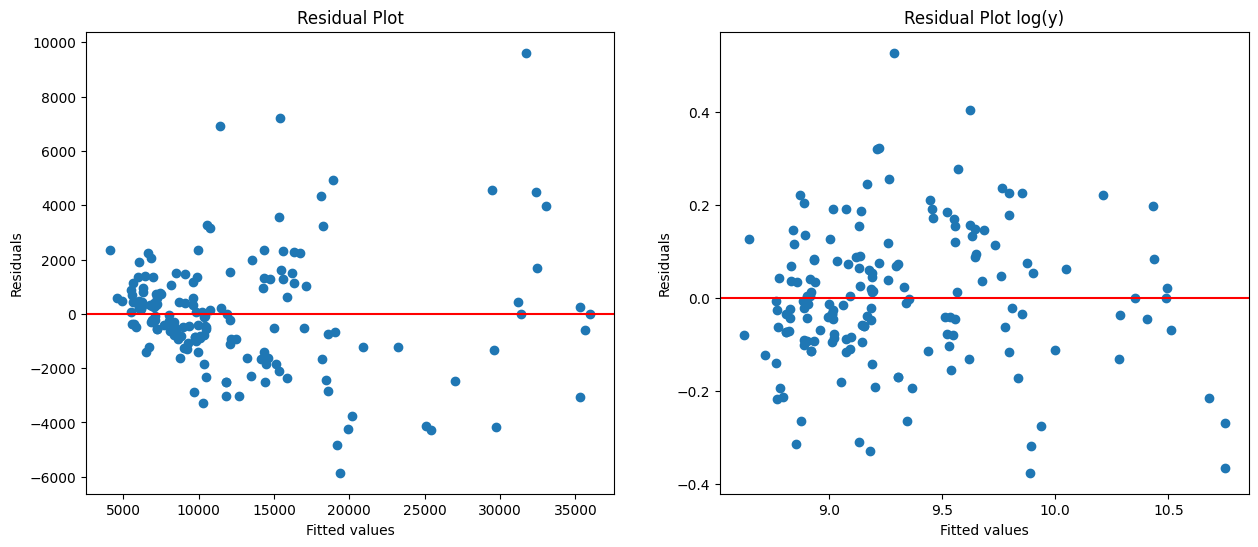

In [45]:
residuals = model.resid
# Calculate the predicted values
fitted_values = model.fittedvalues

# Plot the residuals against the fitted values
fig , ax = plt.subplots(1 , 2 ,figsize=(15,6))

ax[0].scatter(fitted_values, residuals )
ax[0].axhline(y=0, color='r', linestyle='-')
ax[0].set_xlabel("Fitted values")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Residual Plot") 

# transform y to log(y) to compare the residual plot
X_train_tmp ,model = build_model(X_train_rfe,np.log(y_train), print_summary=False)
residuals = model.resid
fitted_values = model.fittedvalues
ax[1].scatter(fitted_values, residuals )
ax[1].axhline(y=0, color='r', linestyle='-')
ax[1].set_xlabel("Fitted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residual Plot log(y)")
plt.show()


$Residual plots$

   1. linear regression  assumes that there is a straight-line relationship between the predictors and the response , If the true relationship is far from linear, then virtually all of the conclusions that we draw from the fit are suspect. In addition, the prediction accuracy of the model can be significantly reduced Residual plots are a useful graphical tool for identifying non-linearity.
   
      - as you can see that The red line is a smooth fit to the residuals, which is displayed in order to make it easier to identify any trends. 
   
   
   2. But Another important assumption of the linear regression model is that the error terms have a constant variance, The standard errors, confidence intervals, and hypothesis tests associated with the linear model rely upon this assumption.
   
      - as you can see that the variances of the error terms increase with the value of the response and when we used the log-transformation solved the problem
   
   
   3. Residual plots can be used to identify outliers
   
      - it can be difficult to decide how large a residual needs to be before we consider the point to be an outlier , so we instead of plotting the residuals we can plot the studentized residuals , Observations whose studentized residuals are greater than 3 in absolute value are possible outliers

In [46]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [47]:
X_train_tmp ,model = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     155.9
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           6.61e-75
Time:                        08:59:33   Log-Likelihood:                 79.900
No. Observations:                 164   AIC:                            -137.8
Df Residuals:                     153   BIC:                            -103.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.62

In [48]:
X_train_tmp.drop('carbody_hardtop' , axis = 1 , inplace=True)

In [49]:
X_train_tmp ,model = build_model(X_train_tmp,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     169.7
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           3.18e-75
Time:                        08:59:33   Log-Likelihood:                 77.889
No. Observations:                 164   AIC:                            -135.8
Df Residuals:                     154   BIC:                            -104.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.53

In [50]:
studentized_residuals = model.get_influence().resid_studentized_internal

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


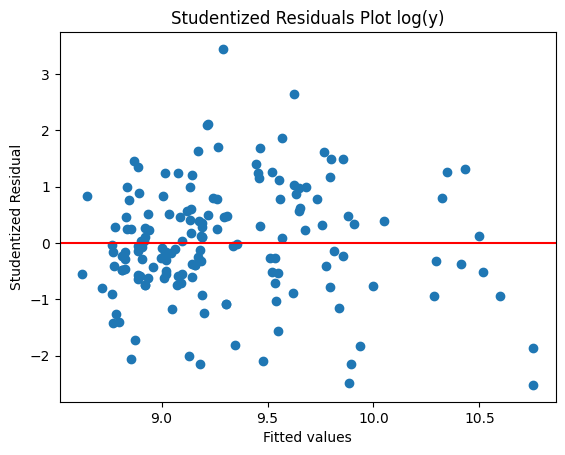

In [51]:
# Checking for the outliers
fitted_values = model.fittedvalues
plt.scatter(fitted_values, studentized_residuals )
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Studentized Residual")
plt.title("Studentized Residuals Plot log(y)")
plt.show()

it seems that we don't have any outliers , what about $Multicollinearity$ ?
because it can be difficult to determine how each one separately is associated with the response

In [52]:
def checkVIF(X):
    'Return the Variance Inflation Factor of the passing dataframe'
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [VIF(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [53]:
checkVIF(X_train_tmp)

,Features,VIF
0,const,31.32
4,carbody_sedan,5.73
3,carbody_hatchback,5.28
2,horsepower,4.42
5,carbody_wagon,3.59
1,curbweight,3.46
7,cylindernumber_four,2.08
9,brandrange_high,1.78
6,enginetype_dohcv,1.36
8,cylindernumber_twelve,1.21


basically what is each number is $$VIF_i = \frac{1}{1 - R_i^2}$$

each $$R_i^2$$ is representing the amount of variance being explained for that ith variable using the remaining variables, so if the remaining variable can explain it with a higher portion that is an indicator of Multicollinearity, As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity, so I guess we could accept all the variable we have​.

In [54]:
X_test.insert(0 , 'const' , [1 for _ in range(len(X_test))])

In [55]:
X_test = X_test[X_train_tmp.columns]

In [56]:
metrics.r2_score(y_test,model.predict(X_test))

0.8990909007194229

In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     169.7
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           3.18e-75
Time:                        08:59:35   Log-Likelihood:                 77.889
No. Observations:                 164   AIC:                            -135.8
Df Residuals:                     154   BIC:                            -104.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.5397      0.068    140.557      0.000       9.406       9.674
curbweight                0.2590      0.023     11.484      0.000       0.214       0.304
horsepower                0.1424      0.026      5.584      0.000       0.092       0.193
carbody_hatchback        -0.2094      0.059     -3.564      0.000      -0.326      -0.093
carbody_sedan            -0.1095      0.058     -1.882      0.062      -0.224       0.005
carbody_wagon            -0.2200      0.067     -3.266      0.001      -0.353      -0.087
enginetype_dohcv         -0.3575      0.182     -1.966      0.051      -0.717       0.002
cylindernumber_four      -0.1261      0.041     -3.071      0.003      -0.207      -0.045
cylindernumber_twelve    -0.5173      0.171     -3.024      0.003      -0.855      -0.179
brandrange_high           0.2797      0.052      5.400      0.000       0.177       0.382
==============================================================================
Omnibus:                        2.866   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                2.776
Skew:                           0.121   Prob(JB):                        0.250
Kurtosis:                       3.590   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

let's interpret the coffient of the model but as we are dealing with the log-transformed dependent variable , we can not say that for one-unit increase in X1  , we expect y to increase/decrease by b1 , holding all other variable constant , we can say that one-unit increase in X1 is associated with a 

$$ e^{(b1-1)} \times 100\% $$ increase in the expected value of y

In [58]:
variable_names = model.params.index[1:]
variable_coefs = model.params.values[1:]
variable_coefs_per = [(np.exp(var) - 1)*100  for var in variable_coefs]

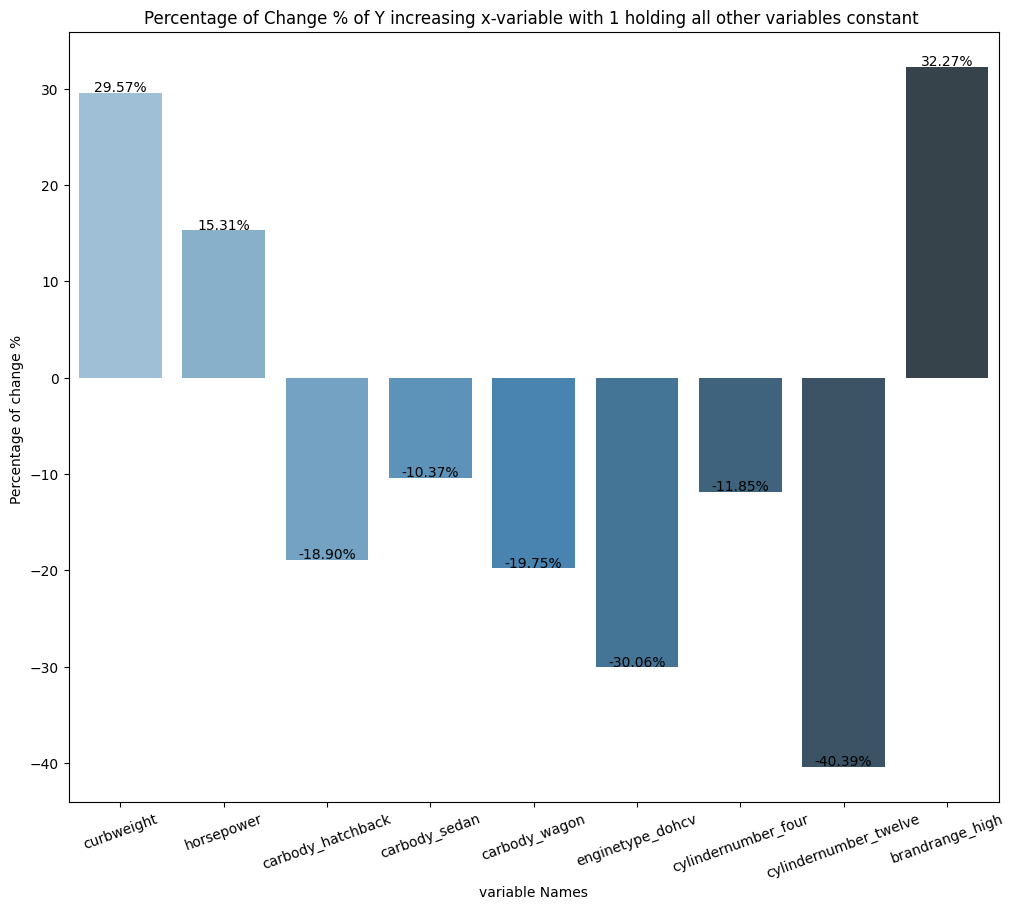

In [59]:
plt.figure(figsize=(12,10))
sns.barplot(x = variable_names , y = variable_coefs_per, palette=("Blues_d"))
for i, value in enumerate(variable_coefs_per):
    plt.text(i, value + 0.1, f"{value:.2f}%", ha="center")
plt.xticks(rotation = 20)
plt.xlabel("variable Names")
plt.ylabel("Percentage of change % ")
plt.title("Percentage of Change % of Y increasing x-variable with 1 holding all other variables constant ")
plt.show()

Okay 
- B0 represent our baseline cases
    -    {'fueltype': 'diesel',
         'aspiration': 'std',
         'carbody': 'convertible',
         'drivewheel': '4wd',
         'enginetype': 'dohc',
         'cylindernumber': 'eight',
         'fuelsystem': '1bbl',
         'brandrange': 'low'}
- B1  represent that increasing the curbweight by 1 , holding all other variables constant, that would increase the price with 29.5%
- B2  represent that increasing the curbweight by 1 , holding all other variables constant, that would increase the price with 15%

till now that is easy to understand 
- B3 represent changing car body from convertible to hatchback , holding all other variables constant, that would reduce the price of the car by -18% and the remaing are the same
